# 1.5e: Cluster Geometry Analysis

This notebook analyzes the spatial geometry of the cluster identified in 1.5d.

We have 3,245 tokens that share `t @ h == h @ h` in bfloat16. Now we want to understand:
- How are they distributed in 2560D space?
- What's the shape? (Ball, cigar, pancake?)
- What's the extent?
- Do we see that characteristic distance distribution?

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Histogram settings
N_BINS = 100
DPI = 200

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load Data

In [3]:
# Load W
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W = load_file(W_path)["W"].to(torch.float32)

print(f"Loaded W from {W_path}")
print(f"  Shape: {W.shape}")

# Load cluster mask from 1.5d
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.5d_cluster_mask.safetensors")
cluster_data = load_file(cluster_path)
cluster_mask = cluster_data["cluster_mask"].to(torch.bool)
n_cluster = cluster_data["n_cluster"].item()

print(f"\nLoaded cluster mask from {cluster_path}")
print(f"  Cluster size: {n_cluster:,} tokens")

Loaded W from ../tensors/Qwen3-4B-Instruct-2507/W.safetensors
  Shape: torch.Size([151936, 2560])

Loaded cluster mask from ../tensors/Qwen3-4B-Instruct-2507/1.5d_cluster_mask.safetensors
  Cluster size: 3,245 tokens


## Extract Cluster Embeddings

In [4]:
print("Extracting cluster embeddings...\n")

# Get cluster embeddings
W_cluster = W[cluster_mask]

print(f"✓ Extracted {W_cluster.shape[0]:,} cluster embeddings")
print(f"  Dimensionality: {W_cluster.shape[1]:,}")

Extracting cluster embeddings...

✓ Extracted 3,245 cluster embeddings
  Dimensionality: 2,560


## Compute Centroid

In [11]:
print("Computing cluster centroid...\n")

# Compute centroid
centroid = W_cluster.mean(dim=0)
centroid_norm = centroid.norm().item()

print(f"Centroid:")
print(f"  Norm: {centroid_norm:.8f}")

Computing cluster centroid...

Centroid:
  Norm: 0.37430960


## L2 Distances from Centroid

In [12]:
print("\nComputing L2 distances from centroid...\n")

# Compute distances
distances = (W_cluster - centroid).norm(dim=1)

print(f"L2 distances from centroid:")
print(f"  Min: {distances.min():.8f}")
print(f"  Max: {distances.max():.8f}")
print(f"  Mean: {distances.mean():.8f}")
print(f"  Median: {distances.median():.8f}")
print(f"  Std: {distances.std():.8f}")
print()
print(f"Extent:")
print(f"  Maximum distance from centroid: {distances.max():.8f}")
print(f"  This defines the 'radius' of the cluster")


Computing L2 distances from centroid...

L2 distances from centroid:
  Min: 0.04956196
  Max: 1.37552452
  Mean: 0.35333386
  Median: 0.04962391
  Std: 0.46722925

Extent:
  Maximum distance from centroid: 1.37552452
  This defines the 'radius' of the cluster


## Distance Distribution Histogram


Plotting distance distribution...



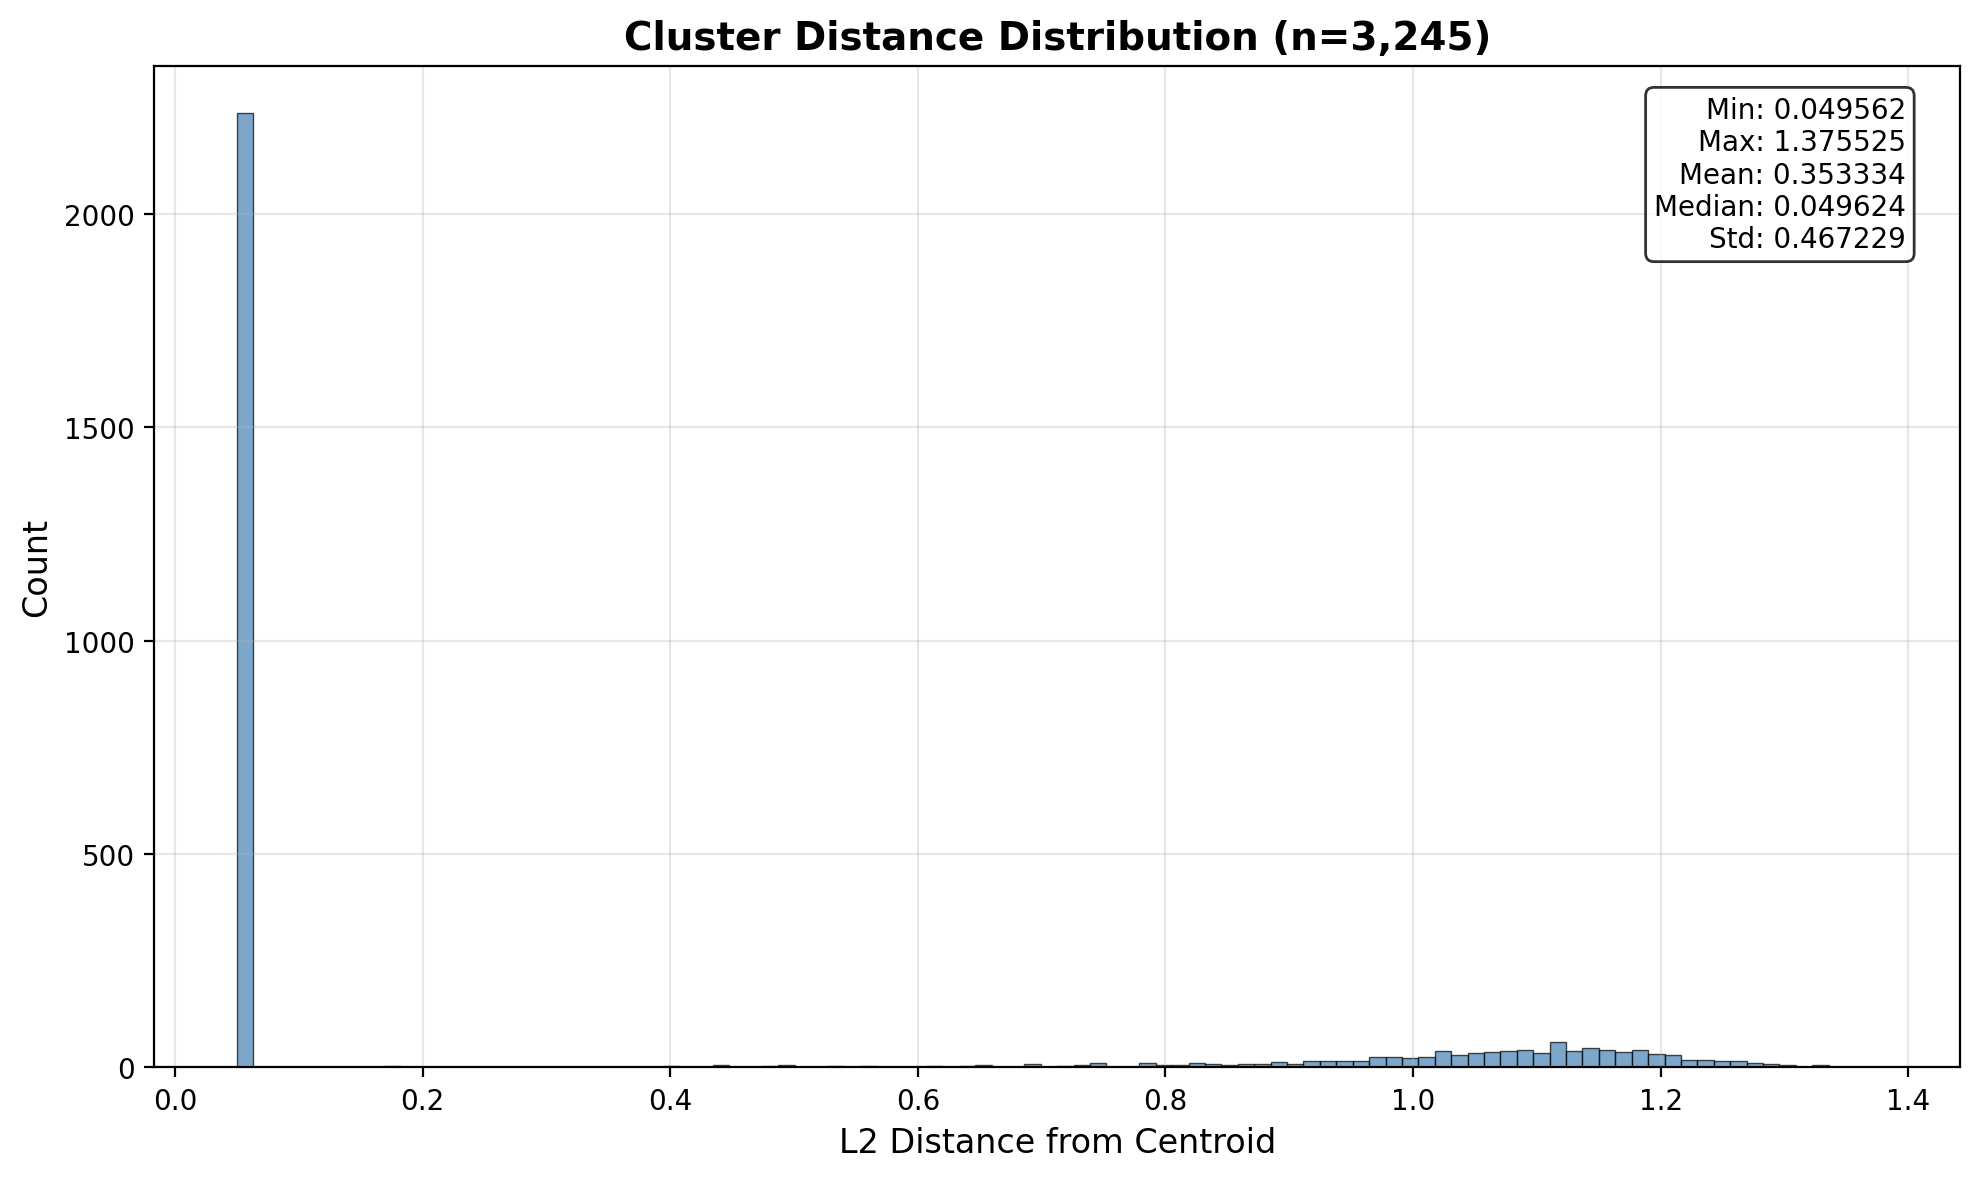

✓ Distance distribution plotted


In [13]:
print("\nPlotting distance distribution...\n")

# Convert to numpy for plotting
distances_np = distances.numpy()

# Create histogram
fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

ax.hist(distances_np, bins=N_BINS, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

ax.set_xlabel('L2 Distance from Centroid', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Cluster Distance Distribution (n={n_cluster:,})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add statistics as text
stats_text = f"Min: {distances.min():.6f}\n"
stats_text += f"Max: {distances.max():.6f}\n"
stats_text += f"Mean: {distances.mean():.6f}\n"
stats_text += f"Median: {distances.median():.6f}\n"
stats_text += f"Std: {distances.std():.6f}"

ax.text(0.97, 0.97, stats_text,
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Distance distribution plotted")

## Shape Analysis via PCA

In [14]:
print("\nAnalyzing cluster shape via PCA...\n")

# Center cluster at its centroid
W_cluster_centered = W_cluster - centroid

# Compute covariance of cluster
cov_cluster = (W_cluster_centered.T @ W_cluster_centered) / n_cluster

# Eigendecomposition
evals_cluster, evecs_cluster = torch.linalg.eigh(cov_cluster)

# Sort descending
idx_cluster = torch.argsort(evals_cluster, descending=True)
evals_cluster = evals_cluster[idx_cluster]

# Compute extent along each principal axis (sqrt of eigenvalue)
extents = torch.sqrt(evals_cluster)

print(f"Principal axis extents (top 10):")
for i in range(min(10, len(extents))):
    print(f"  PC{i+1}: {extents[i]:.8f}")

print()
print(f"Extent ratios (relative to PC1):")
print(f"  PC2/PC1: {extents[1]/extents[0]:.6f}")
print(f"  PC3/PC1: {extents[2]/extents[0]:.6f}")
print(f"  PC10/PC1: {extents[9]/extents[0]:.6f}" if len(extents) >= 10 else "")

print()
print("Shape interpretation:")
if extents[1]/extents[0] > 0.9:
    print("  ~Spherical (PC2/PC1 > 0.9)")
    print("  Tokens are distributed roughly equally in all directions")
elif extents[2]/extents[0] > 0.5:
    print("  ~Ellipsoidal (PC3/PC1 > 0.5)")
    print("  Tokens have preferred directions but aren't extreme")
else:
    print("  Highly elongated/disk-like (PC3/PC1 < 0.5)")
    print("  Tokens are stretched along 1-2 principal axes")


Analyzing cluster shape via PCA...

Principal axis extents (top 10):
  PC1: 0.08204444
  PC2: 0.04586826
  PC3: 0.04052129
  PC4: 0.03800197
  PC5: 0.03649021
  PC6: 0.03560905
  PC7: 0.03483429
  PC8: 0.03425264
  PC9: 0.03303893
  PC10: 0.03299179

Extent ratios (relative to PC1):
  PC2/PC1: 0.559066
  PC3/PC1: 0.493894
  PC10/PC1: 0.402121

Shape interpretation:
  Highly elongated/disk-like (PC3/PC1 < 0.5)
  Tokens are stretched along 1-2 principal axes


## Spherical Coordinate Analysis

In [15]:
print("\nComputing spherical coordinates for cluster...\n")

# First need to compute PCA on full W to get basis vectors
# (using same approach as 1.3c)
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / W.shape[0]
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, idx]

# Define spherical basis (PC2, PC1, PC3 from 1.3c)
north = eigenvectors[:, 1]      # PC2
meridian = eigenvectors[:, 0]   # PC1
equinox = eigenvectors[:, 2]    # PC3

# Project cluster tokens
x = W_cluster @ meridian
y = W_cluster @ equinox
z = W_cluster @ north

# Spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"Latitude range:")
print(f"  [{lat_deg.min():.4f}°, {lat_deg.max():.4f}°]")
print(f"  Span: {(lat_deg.max() - lat_deg.min()):.4f}°")
print()
print(f"Longitude range:")
print(f"  [{lon_deg.min():.4f}°, {lon_deg.max():.4f}°]")
print(f"  Span: {(lon_deg.max() - lon_deg.min()):.4f}°")
print()
print(f"Radius range:")
print(f"  [{r.min():.8f}, {r.max():.8f}]")
print(f"  Span: {(r.max() - r.min()):.8f}")
print(f"  Mean: {r.mean():.8f}")
print(f"  Std: {r.std():.8f}")

print()
print("Interpretation:")
if (lat_deg.max() - lat_deg.min()) > 10:
    print(f"  Large latitude span ({(lat_deg.max() - lat_deg.min()):.1f}°) suggests cluster is NOT tightly localized")
else:
    print(f"  Small latitude span ({(lat_deg.max() - lat_deg.min()):.1f}°) suggests cluster is tightly localized")

if (r.max() - r.min()) / r.mean() > 0.1:
    print(f"  Large radius variation ({(r.max() - r.min()) / r.mean() * 100:.1f}%) suggests radial spread")
else:
    print(f"  Small radius variation ({(r.max() - r.min()) / r.mean() * 100:.1f}%) suggests shell-like structure")


Computing spherical coordinates for cluster...

Latitude range:
  [-21.9738°, 27.5695°]
  Span: 49.5434°

Longitude range:
  [-25.2425°, 22.8756°]
  Span: 48.1180°

Radius range:
  [0.30570111, 0.48014653]
  Span: 0.17444542
  Mean: 0.33521643
  Std: 0.03717896

Interpretation:
  Large latitude span (49.5°) suggests cluster is NOT tightly localized
  Large radius variation (52.0%) suggests radial spread


## Summary

In [16]:
print("\n" + "="*60)
print("CLUSTER GEOMETRY SUMMARY")
print("="*60)
print()
print(f"Cluster size: {n_cluster:,} tokens")
print(f"Centroid norm: {centroid_norm:.8f}")
print()
print(f"Extent from centroid:")
print(f"  Max distance: {distances.max():.8f}")
print(f"  Mean distance: {distances.mean():.8f}")
print()
print(f"Shape (via PCA):")
print(f"  PC2/PC1 ratio: {extents[1]/extents[0]:.4f}")
print(f"  PC3/PC1 ratio: {extents[2]/extents[0]:.4f}")
print()
print(f"Spherical extent:")
print(f"  Latitude span: {(lat_deg.max() - lat_deg.min()):.4f}°")
print(f"  Longitude span: {(lon_deg.max() - lon_deg.min()):.4f}°")
print(f"  Radius variation: {(r.max() - r.min()) / r.mean() * 100:.2f}%")
print()
print("="*60)


CLUSTER GEOMETRY SUMMARY

Cluster size: 3,245 tokens
Centroid norm: 0.37430960

Extent from centroid:
  Max distance: 1.37552452
  Mean distance: 0.35333386

Shape (via PCA):
  PC2/PC1 ratio: 0.5591
  PC3/PC1 ratio: 0.4939

Spherical extent:
  Latitude span: 49.5434°
  Longitude span: 48.1180°
  Radius variation: 52.04%

